In [109]:
from cfdmod.use_cases.hfpi import solver, handler, analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pathlib

analysis.set_plt_style()

### Report directory
base_base = pathlib.Path("/mnt/disk01/prd-eng/portfolio-eng/simulation_files/petra_nova_fluidmechanics/comparison/dynamic_analysis")
subproject_path = base_base / "subproj_main"
structure_path = base_base / "struct_original"
case_path = subproject_path / "out"
data_path = subproject_path / "forces/"

base_folder = pathlib.Path("/mnt/disk01/prd-eng/cases/petra_nova_fluidmechanics/engmod_case")
experimental_data_path = base_folder / "../comparison/force_by_floor/exp_csv/"



In [110]:
### building dimensions
H = 250.424
Bx = 69.14
By = 90.6
B = max(Bx, By)

dimensions = handler.DimensionSpecs(base=B, height=H)

In [111]:
modes_csv = structure_path / "modes.csv"

n_modes = 12
floors_csv = structure_path / "nodes.csv"
phi_csvs = [structure_path / f"phi_{i}.csv" for i in range(1, n_modes+1)]

struct_data = solver.HFPIStructuralData.build(
    modes_csv=modes_csv,
    floors_csv=floors_csv,
    phi_floors_csvs=phi_csvs,
    max_active_modes=5,
)

In [112]:
directions = ["000", "030", "060", "090", "120", "150", "180", "210", "240", "270", "300", "330"]
# directions = ["000"]
float_directions = [float(d) for d in directions]
recurrence_periods = [1, 10, 50]
xis = [0.01, 0.02]

In [113]:
directional_forces = {}

for d in directions:
    cf_x_h5 = data_path / f"FX_{d}.h5"
    cf_y_h5 = data_path / f"FY_{d}.h5"
    cm_z_h5 = data_path / f"MZ_{d}.h5"
    forces_data = solver.HFPIForcesData.build(cf_x_h5, cf_y_h5, cm_z_h5)
    directional_forces[float(d)] = forces_data

directional_forces.keys()

dict_keys([0.0, 30.0, 60.0, 90.0, 120.0, 150.0, 180.0, 210.0, 240.0, 270.0, 300.0, 330.0])

In [114]:
wind_analytical = handler.WindAnalysis(
    directional_velocity_multiplier={d: 1 for d in float_directions},
    directional_roughness_cats=pd.DataFrame(),
)

In [115]:
results_save = pathlib.Path("/mnt/dev01_fs_shared/waine/repos/cfdmod/output/hfpi_test")
analysis_full = handler.HFPIAnalysisHandler(
    wind_analytics=wind_analytical,
    dimensions=dimensions,
    structural_data=struct_data,
    directional_forces=directional_forces,
    save_folder=results_save,
)

In [116]:
all_parameters = analysis_full.generate_combined_parameters(
    directions=float_directions,
    recurrence_periods=recurrence_periods,
    xis=xis,
)


In [117]:
results = handler.HFPIFullResults.load_all_results(results_folder=results_save, parameters=all_parameters)


In [118]:
max_acceleration = results.filter_by_xi(xi=0.01).get_max_acceleration_by_recurrence_period()

max_acceleration

{1.0: np.float64(0.07285408999205743),
 10.0: np.float64(0.19511385731532382),
 50.0: np.float64(1.6701925579261132)}

In [119]:
results_use = results.filter_by_xi(0.01).filter_by_recurrence_period(50)

stats = results_use.get_global_peaks_by_direction()
stats

{'forces_static':     direction         min_x  ...        mean_y        mean_z
 0         0.0  5.863503e+04  ... -1.807239e+07  4.604945e+08
 1        30.0 -6.561389e+06  ... -1.177010e+07  1.180805e+08
 2        60.0 -6.310043e+06  ... -1.139777e+07  7.422883e+07
 3        90.0 -1.100227e+07  ... -8.111750e+06  9.594944e+06
 4       120.0 -1.114068e+07  ... -1.792604e+06 -3.522051e+07
 5       150.0 -9.641145e+06  ...  3.129646e+06 -5.374067e+07
 6       180.0 -4.626337e+06  ...  7.841517e+06 -3.340393e+07
 7       210.0 -7.342395e+04  ...  1.118535e+07 -4.277569e+06
 8       240.0  1.164849e+06  ...  1.090730e+07 -2.307138e+07
 9       270.0  2.742862e+06  ...  8.119534e+06 -4.826492e+07
 10      300.0  3.061107e+06  ...  5.317929e+06 -6.270578e+07
 11      330.0  1.642042e+06  ... -4.235947e+06  5.280568e+07
 
 [12 rows x 10 columns],
 'moments_static':     direction         min_x  ...        mean_y        mean_z
 0         0.0 -3.273369e+07  ... -1.799981e+09  4.604945e+08
 1      

In [120]:
stats["forces_static_eq"]

,direction,min_x,min_y,min_z,max_x,max_y,max_z,mean_x,mean_y,mean_z
0,0.0,-5.645067e+07,-2.737012e+08,-4.744234e+07,7.764443e+07,2.513674e+07,3.928036e+07,1.213746e+07,-1.047267e+08,-5.130986e+06
1,30.0,-5.034546e+07,-1.456138e+08,-2.125317e+07,5.548343e+07,1.815443e+07,1.794875e+07,4.377880e+06,-5.764604e+07,-6.161683e+05
2,60.0,-3.023391e+07,-1.209599e+08,-2.335839e+07,5.124348e+07,1.815503e+07,1.995217e+07,4.100512e+06,-4.684898e+07,-3.530829e+05
3,90.0,-4.795130e+07,-9.982170e+07,-1.314440e+07,1.793973e+07,3.171309e+07,2.407094e+07,-1.385102e+07,-2.982920e+07,5.026119e+06
4,120.0,-6.869901e+07,-9.926845e+07,-3.310411e+07,2.644082e+07,9.143838e+07,4.646275e+07,-1.745346e+07,-1.757121e+06,8.354285e+06
5,150.0,-6.516370e+07,-6.322205e+07,-2.230363e+07,2.423987e+07,1.153645e+08,3.734551e+07,-1.537961e+07,1.424915e+07,7.478013e+06
6,180.0,-3.997631e+07,-2.214827e+07,-1.317659e+07,3.148111e+07,1.105293e+08,2.857650e+07,-5.556510e+06,3.497526e+07,6.350931e+06
7,210.0,-3.783317e+07,-3.558726e+07,-2.731872e+07,8.382871e+07,1.403558e+08,2.886980e+07,1.724667e+07,4.667874e+07,3.707695e+06
8,240.0,-2.811638e+07,-2.406146e+07,-2.706586e+07,4.729815e+07,1.430085e+08,2.692640e+07,9.940982e+06,4.876829e+07,1.351304e+06
9,270.0,-1.180518e+07,-3.496221e+07,-3.287008e+07,6.160814e+07,1.230517e+08,1.555735e+07,1.691089e+07,4.619772e+07,-7.212633e+06


In [121]:
stats["forces_static"]

,direction,min_x,min_y,min_z,max_x,max_y,max_z,mean_x,mean_y,mean_z
0,0.0,5.863503e+04,-3.001204e+07,2.523949e+08,1.217909e+07,-9.569276e+06,7.614236e+08,5.243778e+06,-1.807239e+07,4.604945e+08
1,30.0,-6.561389e+06,-2.042395e+07,6.365026e+07,3.330153e+06,-6.176961e+06,2.055938e+08,-8.277995e+05,-1.177010e+07,1.180805e+08
2,60.0,-6.310043e+06,-1.957019e+07,3.107602e+07,6.508095e+05,-5.700995e+06,1.536392e+08,-2.586938e+06,-1.139777e+07,7.422883e+07
3,90.0,-1.100227e+07,-1.511637e+07,-2.116529e+07,-3.849257e+06,-3.905584e+06,5.949489e+07,-6.688920e+06,-8.111750e+06,9.594944e+06
4,120.0,-1.114068e+07,-5.838663e+06,-6.640272e+07,-3.551868e+06,3.989858e+06,-1.031863e+07,-6.401213e+06,-1.792604e+06,-3.522051e+07
5,150.0,-9.641145e+06,-6.705933e+05,-1.018066e+08,-1.603313e+06,6.678951e+06,-2.299252e+07,-4.811016e+06,3.129646e+06,-5.374067e+07
6,180.0,-4.626337e+06,3.330444e+06,-6.396672e+07,2.691467e+06,1.299222e+07,-2.399342e+06,-1.472854e+06,7.841517e+06,-3.340393e+07
7,210.0,-7.342395e+04,4.728820e+06,-4.402294e+07,1.023668e+07,1.966653e+07,3.685708e+07,4.697278e+06,1.118535e+07,-4.277569e+06
8,240.0,1.164849e+06,5.344866e+06,-5.938967e+07,8.170288e+06,1.916230e+07,8.383179e+05,4.002410e+06,1.090730e+07,-2.307138e+07
9,270.0,2.742862e+06,3.488745e+06,-9.908304e+07,1.069608e+07,1.414286e+07,-1.589779e+07,6.081064e+06,8.119534e+06,-4.826492e+07


39280362.5432578 761423572.1484375
-47442337.21126439 252394934.5546875


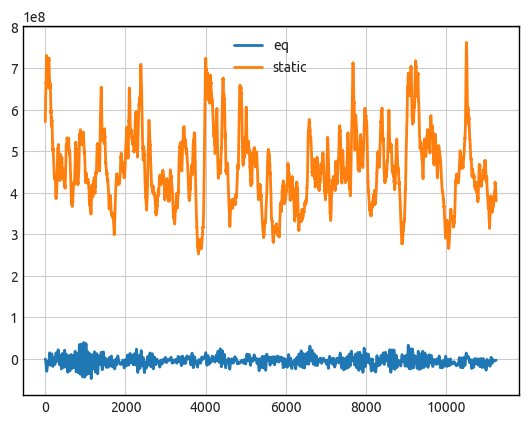

In [122]:
res_0 = list(results_use.results.values())[0]
d = "z"

plt.plot(
    res_0.global_moments_static_eq[d], label="eq"
)
plt.plot(
    res_0.static_results.global_moments_static[d], label="static"
)
plt.legend()
print(max(res_0.global_moments_static_eq[d]), max(res_0.static_results.global_moments_static[d]))
print(min(res_0.global_moments_static_eq[d]), min(res_0.static_results.global_moments_static[d]))

/tmp/ipykernel_341596/3414808333.py:103: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


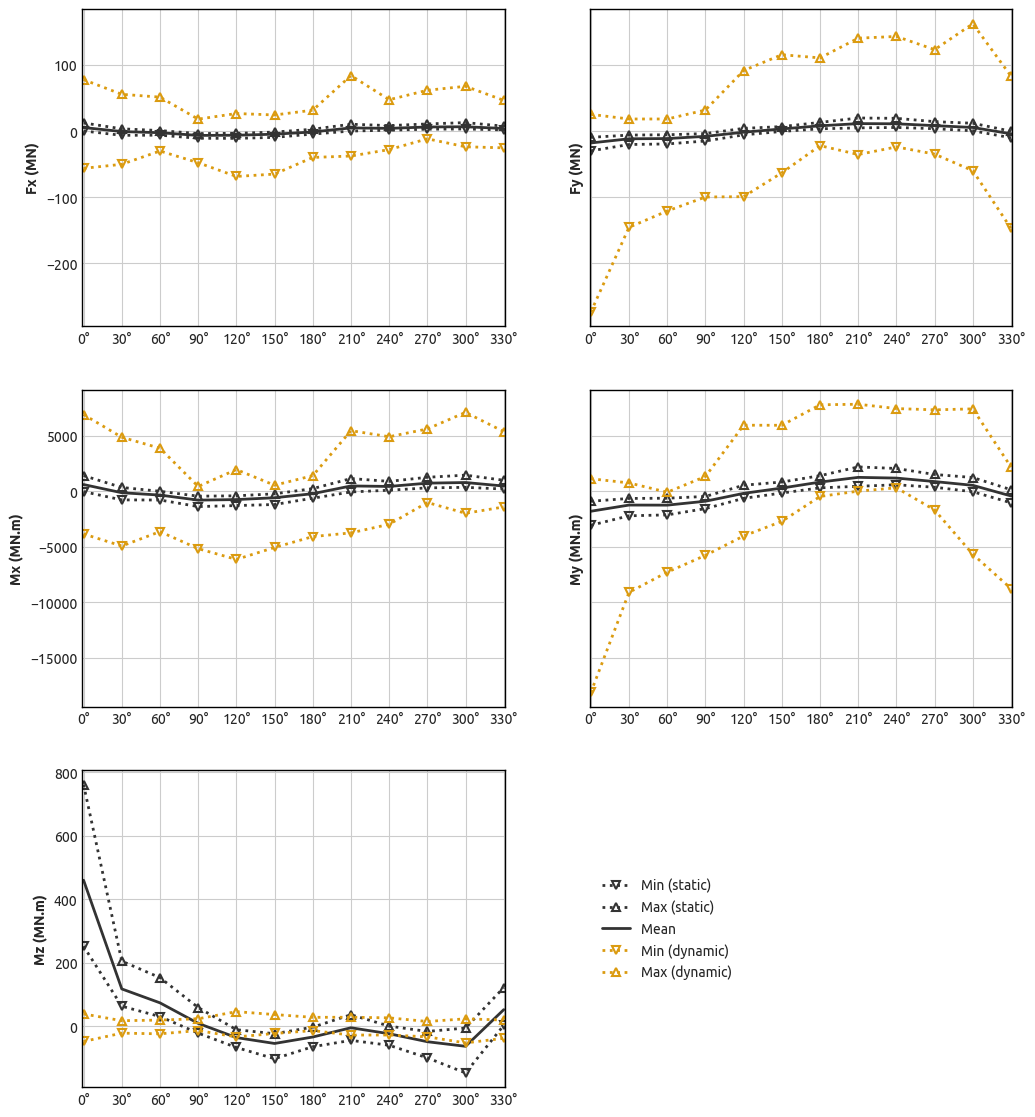

In [123]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from cfdmod.use_cases.hfpi import analysis
from typing import Literal
from matplotlib.ticker import FuncFormatter

analysis.set_plt_style()


plot_style = {
    "AeroSim": {
        "line": {"label": r"$\bf{AeroSim}$", "color": "#E69F00", "linestyle": "-"},
        "marker": {"color": "#E69F00", "markeredgewidth": 1.7, "linestyle": "none"},
    },
}

def plot_global_stats_results(
    ax,
    df: pd.DataFrame,
    direction: Literal["x", "y", "z"],
    *,
    color: str,
    is_dynamic: bool,
    plot_mean: bool,
    **plot_kwargs,
):
    d = direction

    kwargs = plot_kwargs.copy()
    kwargs["fillstyle"] = "none"
    kwargs["color"] = color
    kwargs["markersize"] = 6
    kwargs["markerfacecolor"] = "none"
    kwargs["markeredgecolor"] = color
    kwargs["markeredgewidth"] = 1.5
    txt_lg = "dynamic" if is_dynamic else "static"

    ax.plot(df["direction"], df[f"min_{d}"] / 1e6, "v:", label=f"Min ({txt_lg})", **kwargs)
    ax.plot(df["direction"], df[f"max_{d}"] / 1e6, "^:", label=f"Max ({txt_lg})", **kwargs)
    if plot_mean:
        ax.plot(df["direction"], df[f"mean_{d}"] / 1e6, "-", label="Mean", **kwargs)


def style_global_stats_plot(
    fig,
    ax,
    *,
    scalar_name: str,
    unit: str = "MN",
    ticks_interval: float = 45,
    max_dir: float = 350,
):
    # ax.set_xlabel("Wind Direction (degrees)")
    ax.set_ylabel(f"{scalar_name} ({unit})", weight="bold")
    ax.set_xticks(np.arange(0, max_dir + 1, ticks_interval))
    ax.set_xlim(0-1, max_dir+1)
    ax.xaxis.set_major_formatter(FuncFormatter(lambda val, _: f"{val:.0f}°"))
    # ax.set_title(f"{scalar_name}", weight="bold")


def plot_all_results(stats: dict[str, pd.DataFrame]):
    fig, ax = plt.subplots(3, 2, figsize=(12, 14), sharey="row")
    ax[2, 1].set_visible(False)

    directions = stats["forces_static"]["direction"].to_numpy()
    max_dir = directions.max()
    ticks = max(30, directions[1] - directions[0])

    color_static = "#333333"
    color_eq = "#DB9B10"

    k = "forces_static"
    for d, ij in [("x", (0, 0)), ("y", (0, 1))]:
        style_global_stats_plot(
            fig, ax[ij], scalar_name=f"F{d}", unit="MN", ticks_interval=ticks, max_dir=max_dir
        )
        plot_global_stats_results(
            ax[ij], stats[k], d, color=color_static, is_dynamic=False, plot_mean=True
        )
        plot_global_stats_results(
            ax[ij], stats[f"{k}_eq"], d, color=color_eq, is_dynamic=True, plot_mean=False
        )

    k = "moments_static"
    for d, ij in [("x", (1, 0)), ("y", (1, 1)), ("z", (2, 0))]:
        plot_global_stats_results(
            ax[ij], stats[k], d, color=color_static, is_dynamic=False, plot_mean=True
        )
        plot_global_stats_results(
            ax[ij], stats[f"{k}_eq"], d, color=color_eq, is_dynamic=True, plot_mean=False
        )
        style_global_stats_plot(
            fig, ax[ij], scalar_name=f"M{d}", unit="MN.m", ticks_interval=ticks, max_dir=max_dir
        )

    ax[2, 0].legend(loc="center left", bbox_to_anchor=(1.2, 0.5))

    return fig, ax


fig, ax = plot_all_results(stats)
fig.show()

In [ ]:
results_acceleration = results.filter_by_xi(0.01)

max_acc = results_acceleration.get_max_acceleration_by_recurrence_period()
max_acc

{1.0: np.float64(0.07285408999205743),
 10.0: np.float64(0.19511385731532382),
 50.0: np.float64(1.6701925579261132)}

In [ ]:
import math

def get_codes_max_acceleration(f1: float):
    units_factor = 1
    nbr_6123 = units_factor * 0.01 * 4.08 * f1 ** (-0.445)
    melbourne = (units_factor
            * math.sqrt(2 * math.log(600 * f1))
            * (0.68 + math.log(10) / 5)
            * math.exp(-3.65 - 0.41 * math.log(f1)))
    nbcc_res = 15
    nbcc_office = 25
    return {
        "NBR 6123": (1, nbr_6123),
        "Melbourne (1992)": (10, melbourne),
        "NBCC residential": (10, nbcc_res),
        "NBCC office": (10, nbcc_office),
    }



